## Chest X-Ray multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Imports, cheking directory structure and file exaples

In [2]:
from fastai.conv_learner import *

In [3]:
from fastai.model import *

In [4]:
PATH = 'data/'

In [5]:
from fastai.plots import *

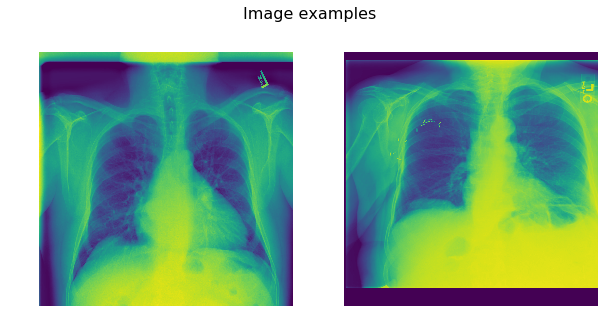

In [6]:
list_paths = [f"{PATH}images/00000001_001.jpg", f"{PATH}images/00000003_002.jpg"]

plots_from_files(list_paths, maintitle="Image examples")

### Choosing model 

In [7]:
model = resnet34

### Data preprocessing, train/val split

In [14]:
df = pd.read_csv(f'{PATH}Data_Entry_2017.csv')

In [15]:
df.head(3)

,Unnamed: 0,Image Index,Finding Labels
0,0,00000001_000.png,Cardiomegaly
1,1,00000001_001.png,Cardiomegaly|Emphysema
2,2,00000001_002.png,Cardiomegaly|Effusion


In [16]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [17]:
df.replace('No Finding', 'No_Finding', regex=True, inplace=True)

In [18]:
df['Finding Labels'] = df['Finding Labels'].str.replace('|',' ')

In [19]:
df.replace('png', 'jpg', regex=True, inplace=True)

In [20]:
df.to_csv('data/labels.csv', index = False)

In [21]:
# val_idxs - random 20% of the dataset
label_csv = 'data/labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [22]:
len(val_idxs) 

22424

### Cheking .csv file

In [23]:
!head -5 'data/labels.csv'

Image Index,Finding Labels
00000001_000.jpg,Cardiomegaly
00000001_001.jpg,Cardiomegaly Emphysema
00000001_002.jpg,Cardiomegaly Effusion
00000002_000.jpg,No_Finding


In [24]:
bs = 32
sz = 256

### Generating data for training

In [25]:
def get_data(sz):
    stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    tfms = tfms_from_stats(stats, sz, aug_tfms=None, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, folder = 'images', csv_fname= 'data/labels.csv', bs = bs, tfms=tfms, val_idxs=val_idxs)

In [26]:
data = get_data(sz)

In [27]:
x,y = next(iter(data.val_dl))

In [28]:
list(zip(data.classes, y))

[('Atelectasis', 
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   1
   0
   0
   0
   0
  [torch.cuda.FloatTensor of size 15 (GPU 0)]), ('Cardiomegaly', 
   0
   1
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
  [torch.cuda.FloatTensor of size 15 (GPU 0)]), ('Consolidation', 
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   1
   0
   0
   0
   0
  [torch.cuda.FloatTensor of size 15 (GPU 0)]), ('Edema', 
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   1
   0
   0
   0
   0
  [torch.cuda.FloatTensor of size 15 (GPU 0)]), ('Effusion', 
   0
   0
   0
   0
   0
   0
   0
   0
   1
   0
   0
   0
   0
   0
   0
  [torch.cuda.FloatTensor of size 15 (GPU 0)]), ('Emphysema', 
   0
   0
   0
   0
   0
   1
   0
   0
   0
   0
   0
   0
   0
   0
   1
  [torch.cuda.FloatTensor of size 15 (GPU 0)]), ('Fibrosis', 
   0
   0
   0
   0
   1
   0
   0
   0
   1
   0
   0
   0
   0
   0
   0
  [torch.cuda.FloatTensor of size 15 (GPU 0)]), ('Hernia', 
   0
   0
   0
   

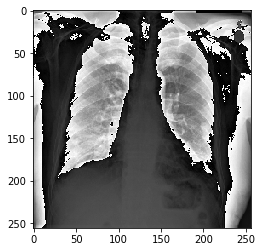

In [23]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [29]:
learn = ConvLearner.pretrained(model, data, precompute = False)

### Finding optimal LR

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 1/2803 [00:06<4:54:36,  6.31s/it, loss=0.826]


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 96%|█████████▌| 2686/2803 [21:26<00:56,  2.09it/s, loss=0.842]


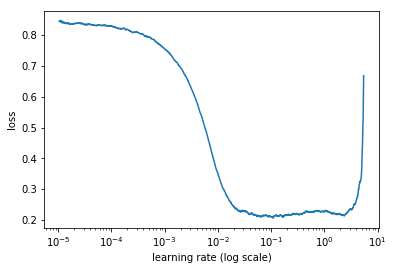

In [115]:
lrf=learn.lr_find()
learn.sched.plot()

In [26]:
lr = 10 ** -2

### Training ANN with differential LR

In [112]:
lrs = np.array([lr/9,lr/3,lr])

In [28]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                      
    0      0.201303   0.191731   0.932253  
    1      0.188405   0.18437    0.933194                      
    2      0.189437   0.183093   0.9334                        
    3      0.182964   0.180174   0.933769                      
    4      0.18193    0.178505   0.933925                      
    5      0.180832   0.177643   0.934234                      
    6      0.177217   0.17746    0.93426                       



[0.17745955, 0.9342595894054407]

In [113]:
lrs = np.array([lr/6,lr/2,lr])

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

### Saving the model

In [32]:
learn.save('model_multi_label')

### Loading the model

In [30]:
learn.load('model_multi_label')

### Analyzing results

In [31]:
log_preds,y = learn.TTA()

In [32]:
probs = np.mean(np.exp(log_preds),0)

In [33]:
probs.shape

(22424, 15)

In [34]:
from sklearn.metrics import roc_auc_score

In [35]:
rocauc_Atelectasis = roc_auc_score(y[:,0], probs[:,0])

In [36]:
rocauc_Cardiomegaly = roc_auc_score(y[:,1], probs[:,1])

In [37]:
rocauc_Consolidation = roc_auc_score(y[:,2], probs[:,2])

In [38]:
rocauc_Edema = roc_auc_score(y[:,3], probs[:,3])

In [39]:
rocauc_Effusion = roc_auc_score(y[:,4], probs[:,4])

In [40]:
rocauc_Emphysema = roc_auc_score(y[:,5], probs[:,5])

In [41]:
rocauc_Fibrosis = roc_auc_score(y[:,6], probs[:,6])

In [42]:
rocauc_Hernia = roc_auc_score(y[:,7], probs[:,7])

In [43]:
rocauc_Infiltration = roc_auc_score(y[:,8], probs[:,8])

In [44]:
rocauc_Mass = roc_auc_score(y[:,9], probs[:,9])

In [45]:
rocauc_No_Finding = roc_auc_score(y[:,10], probs[:,10])

In [46]:
rocauc_Nodule = roc_auc_score(y[:,11], probs[:,11])

In [47]:
rocauc_Pleural_Thickening = roc_auc_score(y[:,12], probs[:,12])

In [48]:
rocauc_Pneumonia = roc_auc_score(y[:,13], probs[:,13])

In [49]:
rocauc_Pneumothorax = roc_auc_score(y[:,14], probs[:,14])

In [51]:
print (f'Atelectasis: {rocauc_Atelectasis}')
print (f'Cardiomegaly: {rocauc_Cardiomegaly}')
print (f'Effusion: {rocauc_Effusion}')
print (f'Infiltration: {rocauc_Infiltration}')
print (f'Mass: {rocauc_Mass}')
print (f'Nodule: {rocauc_Nodule}')
print (f'Pneumonia: {rocauc_Pneumonia}')
print (f'Pneumothorax: {rocauc_Pneumothorax}')
print (f'Consolidation: {rocauc_Consolidation}')
print (f'Edema: {rocauc_Edema}')
print (f'Emphysema: {rocauc_Emphysema}')
print (f'Fibrosis: {rocauc_Fibrosis}')
print (f'Pleural Thickening: {rocauc_Pleural_Thickening}')
print (f'Hernia: {rocauc_Hernia}')
print (f'No pathology: {rocauc_No_Finding}')

Atelectasis: 0.8006300679030167
Cardiomegaly: 0.8950653530618717
Effusion: 0.8759614506745169
Infiltration: 0.7074070000279365
Mass: 0.8159842550845308
Nodule: 0.7241878704288807
Pneumonia: 0.7248084909517355
Pneumothorax: 0.8744398827121108
Consolidation: 0.7828632021704276
Edema: 0.8929285481976065
Emphysema: 0.8769695541245188
Fibrosis: 0.8093287309995965
Pleural Thickening: 0.7763691641743851
Hernia: 0.8223842710426001
No pathology: 0.7733422754415022
